<a href="https://colab.research.google.com/github/Kaggle-Challenge/SpaceshipTitanicChallenge/blob/main/SpaceshipTitanicChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libaries
!pip install shap
!pip install catboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import shap
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


In [ ]:
# Load Data
train = pd.read_csv('https://raw.githubusercontent.com/Revathi343664/SpaceshipTitanicChallenge/refs/heads/main/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Revathi343664/SpaceshipTitanicChallenge/refs/heads/main/test.csv')
submission = pd.read_csv('https://raw.githubusercontent.com/Revathi343664/SpaceshipTitanicChallenge/refs/heads/main/sample_submission.csv')
test_ids = test['PassengerId']

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
print(train.shape)

(8693, 14)


In [ ]:
train.describe(include='all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,9280_02,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Ankalik Nateansive,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [ ]:
# Missing Values Overview
print("Missing values in train:\n", train.isnull().sum())

Missing values in train:
 PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [ ]:
# Cabin Feature Engineering
for df in [train, test]:
    df[['Deck','CabinNum','Side']] = df['Cabin'].str.split('/', expand=True)
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNum,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S


In [ ]:
# Missing Value Imputation
cols_cat = ['HomePlanet','CryoSleep','Destination','VIP','Deck','Side']
cols_num = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','CabinNum']

for df in [train, test]:
    for c in cols_cat:
        df[c].fillna(df[c].mode()[0], inplace=True)
    for c in cols_num:
        df[c].fillna(df[c].median(), inplace=True)

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNum,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S


In [ ]:
# Missing Values Overview
print("Missing values in train:\n", train.isnull().sum())

Missing values in train:
 PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
Deck              0
CabinNum          0
Side              0
dtype: int64


In [ ]:
# Cabin and Name Colums Imputation
for df in [train, test]:
    df['Cabin'].fillna('Unknown/Unknown/0', inplace=True)
    df['Name'].fillna('Unknown', inplace=True)


In [ ]:
# Missing Values Overview
print("Missing values in train:\n", train.isnull().sum())

Missing values in train:
 PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
Deck            0
CabinNum        0
Side            0
dtype: int64


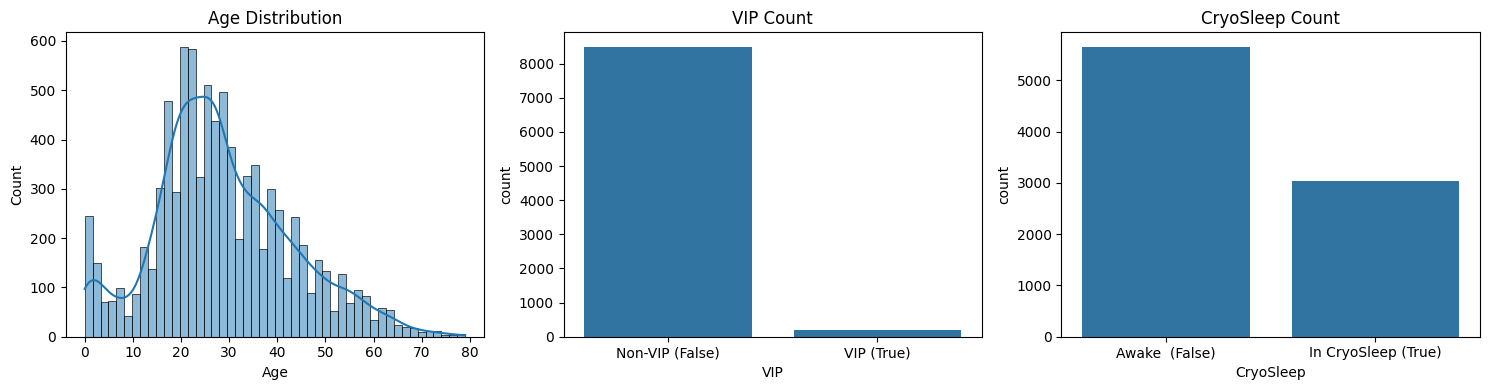

In [ ]:
# Initial EDA
import matplotlib.patches as mpatches
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(train['Age'].dropna(), kde=True, ax=axes[0]).set(title='Age Distribution')
sns.countplot(x='VIP', data=train, ax=axes[1]).set(title='VIP Count'); axes[1].set_xticklabels(['Non-VIP (False)', 'VIP (True)'])
sns.countplot(x='CryoSleep', data=train, ax=axes[2]).set(title='CryoSleep Count'); axes[2].set_xticklabels(['Awake  (False)', 'In CryoSleep (True)'])
plt.tight_layout()
plt.show()

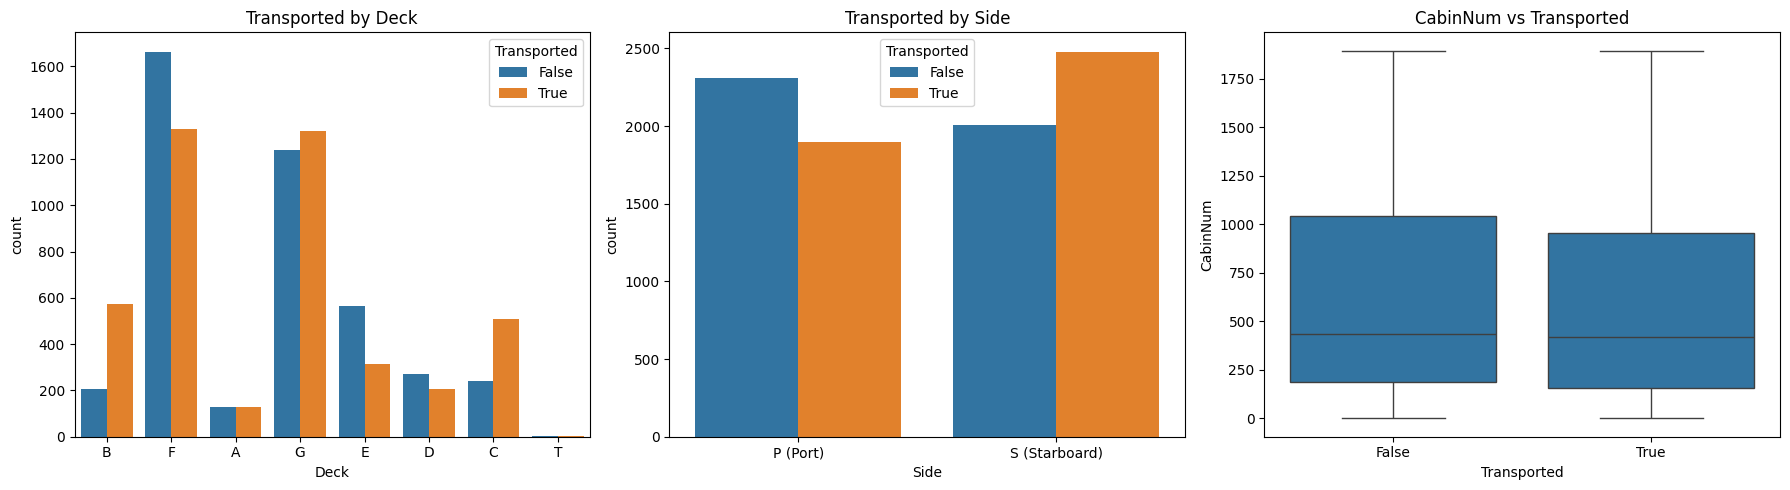

In [ ]:
# Distribution of passengers across different Decks, segmented by Transported status
# Distribution of passengers by Cabin Side, segmented by Transported status
# Boxplot of Cabin numbers showing how they vary with Transported status

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='Deck', hue='Transported', data=train, ax=axes[0]).set_title('Transported by Deck')
sns.countplot(x='Side', hue='Transported', data=train, ax=axes[1]).set_title('Transported by Side'); axes[1].set_xticklabels(['P (Port)', 'S (Starboard)'])
sns.boxplot(x='Transported', y='CabinNum', data=train, ax=axes[2]).set_title('CabinNum vs Transported')
plt.tight_layout()
plt.show()


In [ ]:
# Feature Engineering
for df in [train, test]:
    df['TotalExpenses'] = df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

# Encoding + Scaling
le = LabelEncoder()
for c in cols_cat:
    train[c] = le.fit_transform(train[c].astype(str))
    test[c] = le.transform(test[c].astype(str))

scaler = StandardScaler()
train[cols_num + ['TotalExpenses']] = scaler.fit_transform(train[cols_num + ['TotalExpenses']])
test[cols_num + ['TotalExpenses']] = scaler.transform(test[cols_num + ['TotalExpenses']])

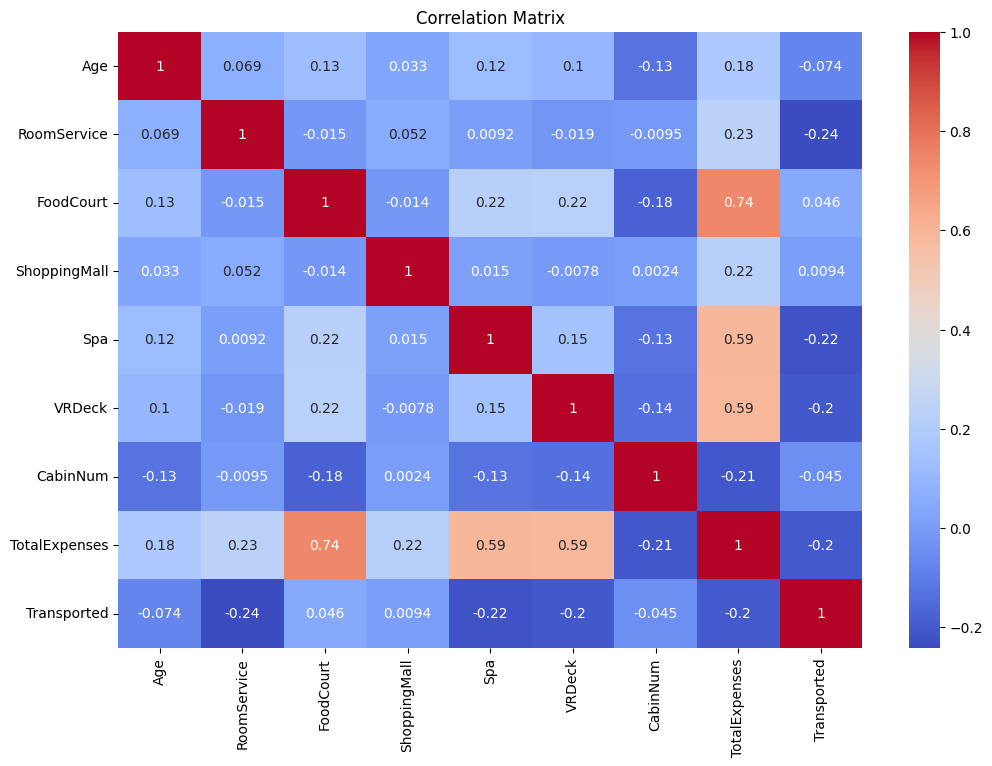

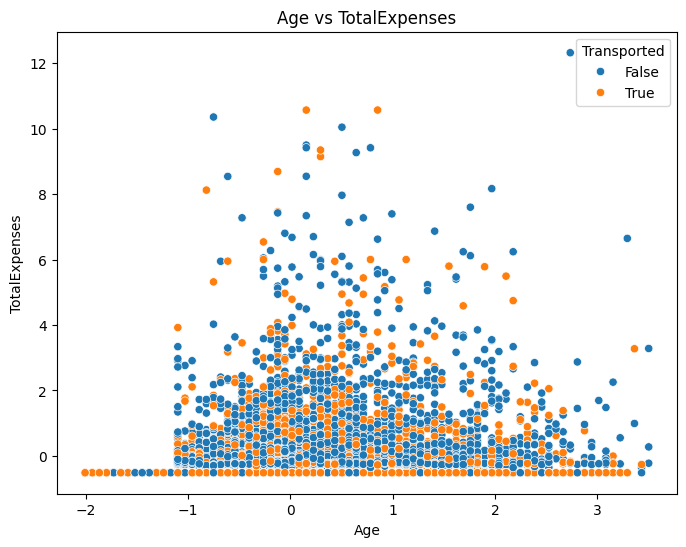

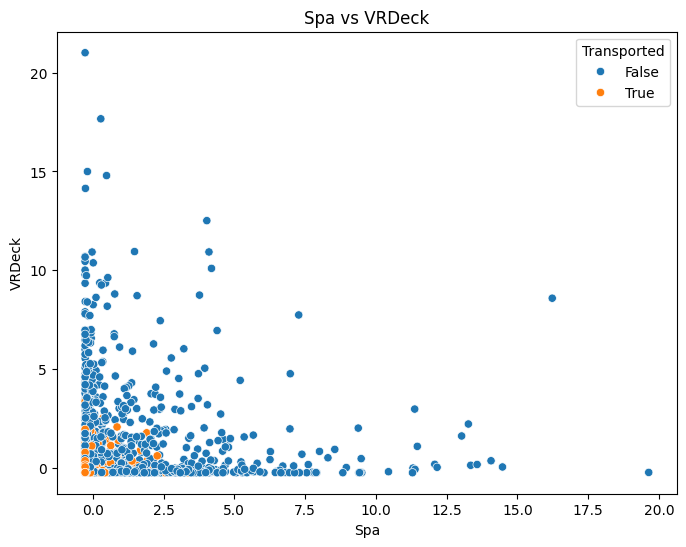

In [ ]:
# Enhanced EDA

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(train[cols_num + ['TotalExpenses'] + ['Transported']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Scatter Plots
plt.figure(figsize=(8,6))
sns.scatterplot(x='Age', y='TotalExpenses', hue='Transported', data=train)
plt.title('Age vs TotalExpenses')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='Spa', y='VRDeck', hue='Transported', data=train)
plt.title('Spa vs VRDeck')
plt.show()

In [ ]:
# Data Preparation for Modeling
X = train.drop(['PassengerId','Name','Cabin','Transported'], axis=1)
y = train['Transported'].astype(int)
X_test = test.drop(['PassengerId','Name','Cabin'], axis=1)

In [ ]:
# Check for missing values in X and X_test
print(X.isnull().sum())
print(X_test.isnull().sum())

# Verify that columns in X_test match those in X both in name and order
print("Columns match:" , list(X.columns) == list(X_test.columns))

HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Deck             0
CabinNum         0
Side             0
TotalExpenses    0
dtype: int64
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Deck             0
CabinNum         0
Side             0
TotalExpenses    0
dtype: int64
Columns match: True


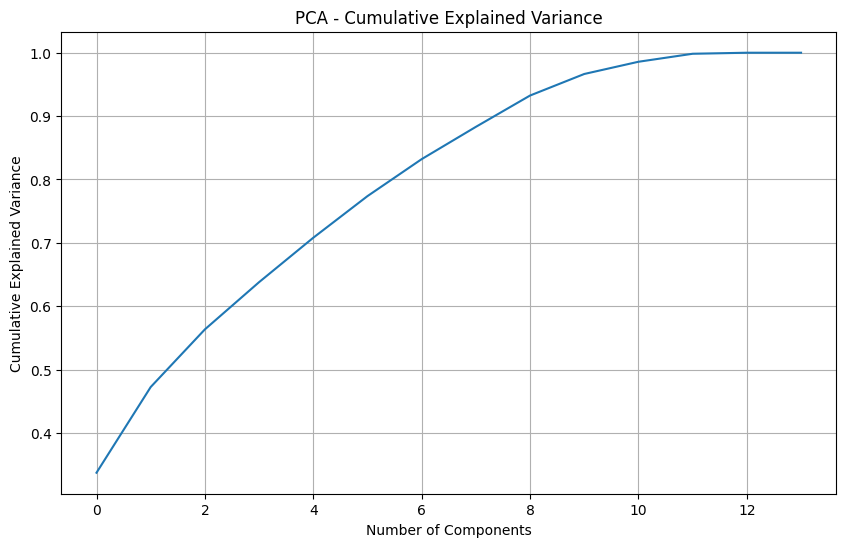

In [ ]:
# Let's decide how many components to keep. We can visualize explained variance.
pca = PCA().fit(X)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
# Based on the plot, we have choosen 10 number of components that explain a good portion of variance nearly 95% because of typical dataset.
# We have adjusted `n_components` based on the Elbow point or desired explained variance from the plot above.
pca_n_components = min(10, X.shape[1])

pca_transformer = PCA(n_components=pca_n_components)
X_pca = pca_transformer.fit_transform(X)
X_test_pca = pca_transformer.transform(X_test)

print(f"\nOriginal number of features: {X.shape[1]}")
print(f"Number of features after PCA: {X_pca.shape[1]}")


Original number of features: 14
Number of features after PCA: 10


In [ ]:
# Model Training with Hyperparameter Tuning and Cross-Validation

# Creating StratifiedKFold for robust evaluation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# XGBoost Classifier
print("\n--- Training XGBoost Classifier with Hyperparameter Tuning ---")

# Define parameter grid for RandomizedSearchCV (more efficient than GridSearchCV for large spaces)
# For a full GridSearchCV, define a smaller, more focused grid after initial exploration.
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'lambda': [0.1, 1, 5], # L2 regularization term
    'alpha': [0, 0.1, 0.5] # L1 regularization term
}

# Use RandomizedSearchCV for faster initial exploration
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_random_search = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=30, cv=skf,
                                       scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
# Using original features for tuning initially. You can also tune on PCA features.
xgb_random_search.fit(X, y)

print(f"Best XGBoost parameters: {xgb_random_search.best_params_}")
print(f"Best XGBoost cross-validation accuracy: {xgb_random_search.best_score_:.4f}")

best_xgb_model = xgb_random_search.best_estimator_


--- Training XGBoost Classifier with Hyperparameter Tuning ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGBoost parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 1.0, 'alpha': 0.1}
Best XGBoost cross-validation accuracy: 0.8119


In [ ]:
# LightGBM Classifier
print("\n--- Training LightGBM Classifier with Hyperparameter Tuning ---")

lgbm_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 40, 50],
    'max_depth': [-1, 5, 7, 9], # -1 means no limit
    'min_child_samples': [20, 30, 40],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5], # L1 regularization
    'reg_lambda': [0.1, 1, 5] # L2 regularization
}

lgbm_model = LGBMClassifier(random_state=42)
lgbm_random_search = RandomizedSearchCV(lgbm_model, lgbm_param_grid, n_iter=30, cv=skf,
                                        scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
# Using original features for tuning
lgbm_random_search.fit(X, y)

print(f"Best LightGBM parameters: {lgbm_random_search.best_params_}")
print(f"Best LightGBM cross-validation accuracy: {lgbm_random_search.best_score_:.4f}")

best_lgbm_model = lgbm_random_search.best_estimator_


--- Training LightGBM Classifier with Hyperparameter Tuning ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1885
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best LightGBM parameters: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.1, 'num_leaves': 20, 'n_estimators': 100, 'min_child_samples': 40, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best LightGBM cross-validation accurac

In [ ]:
# CatBoost Classifier

print("\n--- Training CatBoost Classifier with Hyperparameter Tuning ---")
catboost_params = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.03, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_search = RandomizedSearchCV(cat_model, catboost_params, n_iter=30, cv=skf, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)
cat_search.fit(X, y)

print("Best CatBoost parameters:", cat_search.best_params_)
print(f"Best CatBoost CV accuracy: {cat_search.best_score_:.4f}")
best_cat_model = cat_search.best_estimator_


--- Training CatBoost Classifier with Hyperparameter Tuning ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CatBoost parameters: {'learning_rate': 0.03, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 6}
Best CatBoost CV accuracy: 0.8156


In [ ]:
# Random Forest Classifier
print("\n--- Training Random Forest Classifier with Hyperparameter Tuning ---")
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf_model, rf_param_grid, n_iter=30, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
rf_search.fit(X, y)

print("Best Random Forest parameters:", rf_search.best_params_)
print(f"Best Random Forest CV accuracy: {rf_search.best_score_:.4f}")
best_rf_model = rf_search.best_estimator_



--- Training Random Forest Classifier with Hyperparameter Tuning ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Random Forest parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None, 'bootstrap': True}
Best Random Forest CV accuracy: 0.8073


In [ ]:
# Cross-validation accuracies
print(f"Best XGBoost cross-validation accuracy: {xgb_random_search.best_score_:.4f}")
print(f"Best LightGBM cross-validation accuracy: {lgbm_random_search.best_score_:.4f}")
print(f"Best CatBoost cross-validation accuracy: {cat_search.best_score_:.4f}")
print(f"Best Random Forest cross-validation accuracy: {rf_search.best_score_:.4f}")

Best XGBoost cross-validation accuracy: 0.8119
Best LightGBM cross-validation accuracy: 0.8131
Best CatBoost cross-validation accuracy: 0.8156
Best Random Forest cross-validation accuracy: 0.8073


In [ ]:
# Model Evaluation

# Evaluate the best XGBoost model
y_pred_xgb = best_xgb_model.predict(X)
print(f"\nXGBoost Training Accuracy: {accuracy_score(y, y_pred_xgb):.4f}")

# Evaluate the best LightGBM model
y_pred_lgbm = best_lgbm_model.predict(X)
print(f"LightGBM Training Accuracy: {accuracy_score(y, y_pred_lgbm):.4f}")

# Evaluate the best CatBoost model
y_pred_cat = best_cat_model.predict(X)
print(f"CatBoost Training Accuracy: {accuracy_score(y, y_pred_cat):.4f}")

# Evaluate the best Random Forest model
y_pred_rf = best_rf_model.predict(X)
print(f"Random Forest Training Accuracy: {accuracy_score(y, y_pred_rf):.4f}")


XGBoost Training Accuracy: 0.9166
LightGBM Training Accuracy: 0.8812
CatBoost Training Accuracy: 0.8471
Random Forest Training Accuracy: 0.9018



--- XGBoost Evaluation ---

Confusion Matrix (XGBoost):
[[3926  389]
 [ 336 4042]]


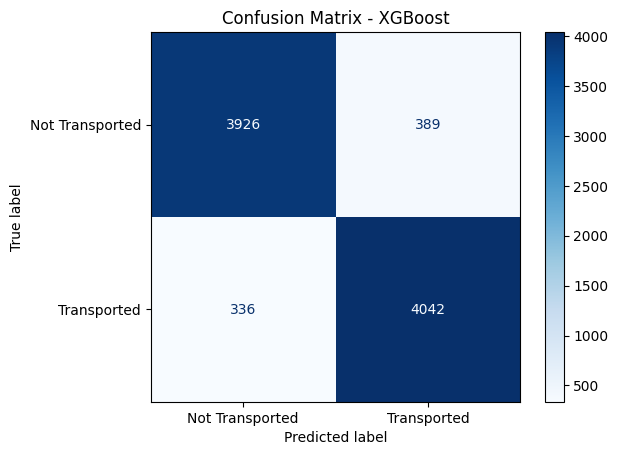


Classification Report (XGBoost):
                 precision    recall  f1-score   support

Not Transported       0.92      0.91      0.92      4315
    Transported       0.91      0.92      0.92      4378

       accuracy                           0.92      8693
      macro avg       0.92      0.92      0.92      8693
   weighted avg       0.92      0.92      0.92      8693


--- LightGBM Evaluation ---

Confusion Matrix (LightGBM):
[[3793  522]
 [ 511 3867]]


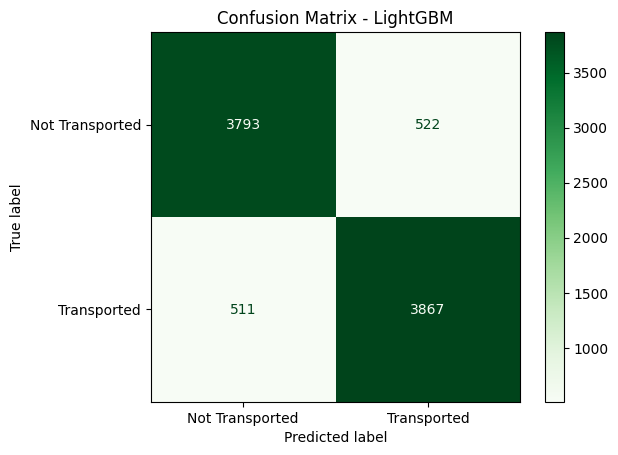


Classification Report (LightGBM):
                 precision    recall  f1-score   support

Not Transported       0.88      0.88      0.88      4315
    Transported       0.88      0.88      0.88      4378

       accuracy                           0.88      8693
      macro avg       0.88      0.88      0.88      8693
   weighted avg       0.88      0.88      0.88      8693


--- CatBoost Evaluation ---

Confusion Matrix (CatBoost):
[[3566  749]
 [ 580 3798]]


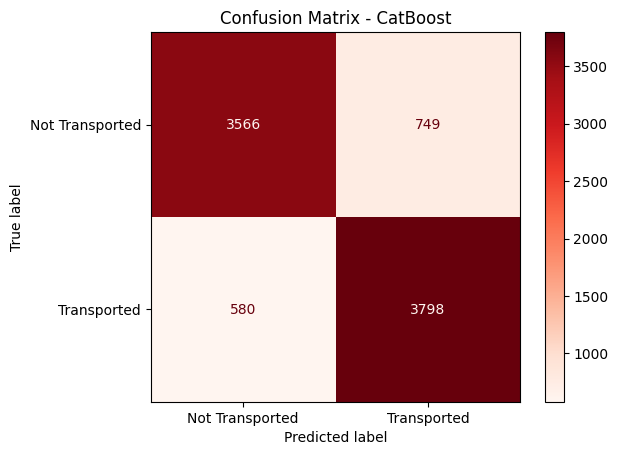


Classification Report (CatBoost):
                 precision    recall  f1-score   support

Not Transported       0.86      0.83      0.84      4315
    Transported       0.84      0.87      0.85      4378

       accuracy                           0.85      8693
      macro avg       0.85      0.85      0.85      8693
   weighted avg       0.85      0.85      0.85      8693


--- Random Forest Evaluation ---

Confusion Matrix (Random Forest):
[[3924  391]
 [ 463 3915]]


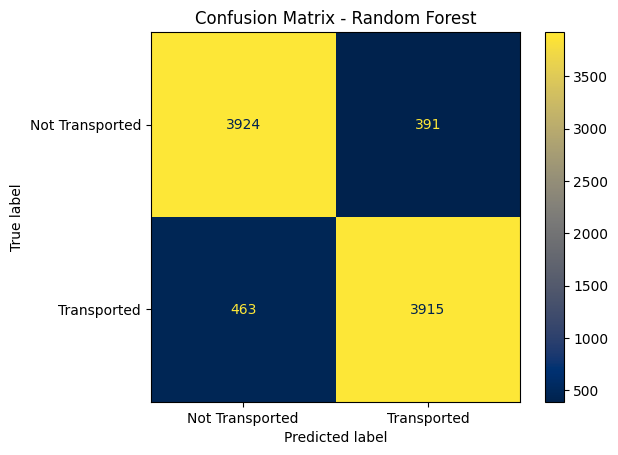


Classification Report (Random Forest):
                 precision    recall  f1-score   support

Not Transported       0.89      0.91      0.90      4315
    Transported       0.91      0.89      0.90      4378

       accuracy                           0.90      8693
      macro avg       0.90      0.90      0.90      8693
   weighted avg       0.90      0.90      0.90      8693



In [ ]:
# Confusion Matrices and Classification Reports
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

models = {
    "XGBoost": (y_pred_xgb, 'Blues'),
    "LightGBM": (y_pred_lgbm, 'Greens'),
    "CatBoost": (y_pred_cat, 'Reds'),
    "Random Forest": (y_pred_rf, 'cividis')
}

for name, (y_pred, color) in models.items():
    print(f"\n--- {name} Evaluation ---")

    cm = confusion_matrix(y, y_pred)
    print(f"\nConfusion Matrix ({name}):\n{cm}")

    ConfusionMatrixDisplay(cm, display_labels=['Not Transported', 'Transported']).plot(cmap=plt.get_cmap(color))
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    print(f"\nClassification Report ({name}):")
    print(classification_report(y, y_pred, target_names=['Not Transported', 'Transported']))

In [ ]:
# Find the Best Model
model_scores = {
    'XGBoost': xgb_random_search.best_score_,
    'LightGBM': lgbm_random_search.best_score_,
    'CatBoost': cat_search.best_score_,
    'Random Forest': rf_search.best_score_
}


best_model_name = max(model_scores, key=model_scores.get)
print(f"The best model is: {best_model_name} with a cross-validation accuracy of {model_scores[best_model_name]:.4f}")

The best model is: CatBoost with a cross-validation accuracy of 0.8156



--- SHAP Feature Importance (for Best CatBoost Model) ---


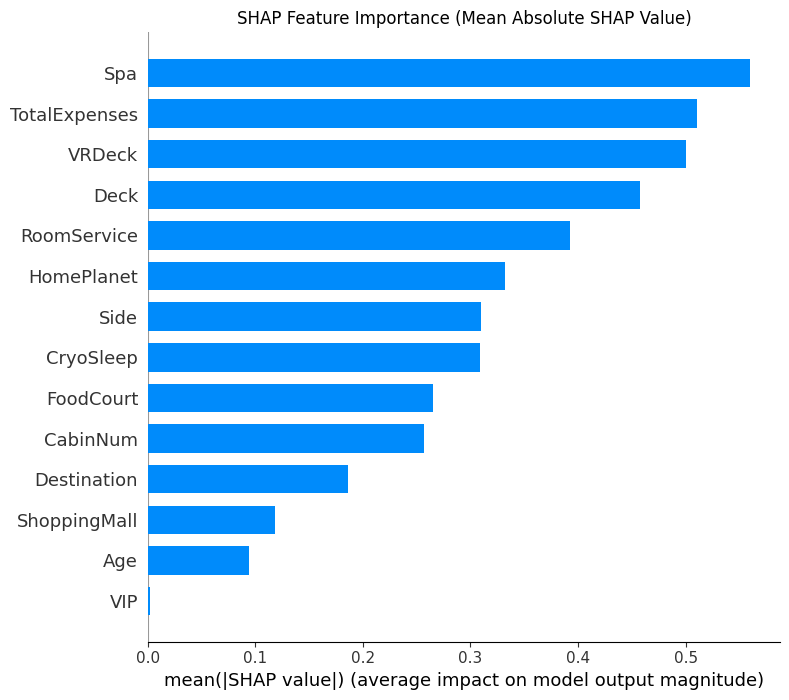

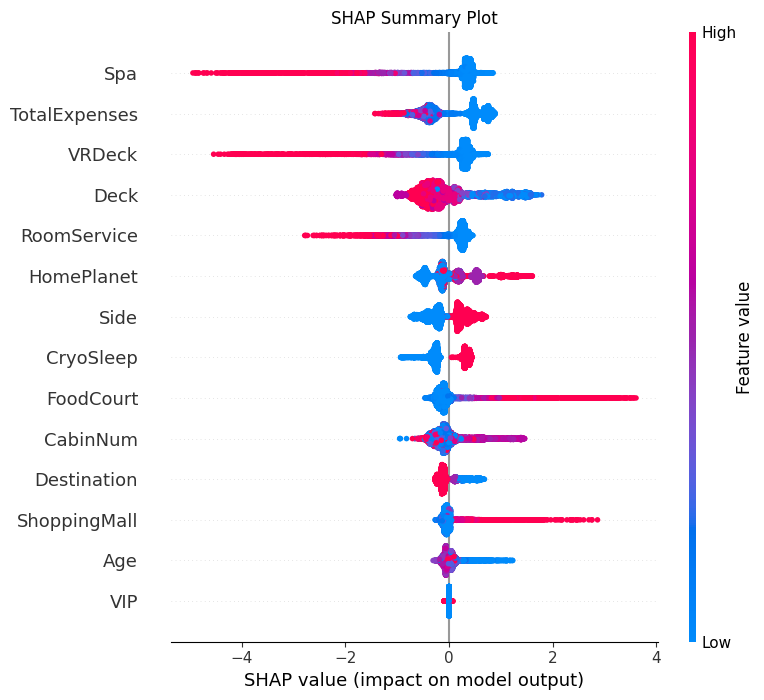

In [ ]:
# Feature Importance (SHAP values for interpretability)
print("\n--- SHAP Feature Importance (for Best CatBoost Model) ---")
# Using the best CatBoost model for SHAP explanation
explainer = shap.TreeExplainer(best_cat_model)
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean Absolute SHAP Value)")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

In [ ]:
# Predictions for Kaggle Submission

# CatBoost Model is used for the final submission, based on cross-validation accuracy and leaderboard score.
# Here, we'll assume CatBoost was slightly better based on CV accuracy.
final_model = best_cat_model

predictions = final_model.predict(X_test)

# Create submission file
submission_df = pd.DataFrame({
    'PassengerId': test['PassengerId'], # Use original test PassengerId
    'Transported': predictions.astype(bool) # Convert to boolean as per Kaggle's requirement
})

submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created successfully!")
print(submission_df.head())


Submission file 'submission.csv' created successfully!
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01        False


In [ ]:
# Code to download the created CSV file
try:
    from google.colab import files
    files.download('submission.csv')
    print("Your 'submission.csv' file should now be downloading.")
except ImportError:
    print("The 'google.colab.files' module is not available.")
    print("This usually means you are not running in a Google Colab environment.")
    print("If you are in a local Jupyter environment, 'submission.csv' is saved in your current directory.")
    print("You can manually download it from your file explorer.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Your 'submission.csv' file should now be downloading.
